In [14]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random
import math

import numpy as np
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
#%matplotlib notebook

from numpy.linalg import inv
from numpy import linalg as LA
from scipy import linalg
import random

from matplotlib import animation, rc
from IPython.display import HTML

In [15]:
n_nodes = 10
n_dofs = n_nodes*2
n_elements = n_nodes-1
x = np.linspace(0, 1, n_nodes)

In [16]:
L = 1000 #mm
rho = 0.006 #kg/mm
E = 210000 #N/mm2
I = 0.801*10**6 #mm4
A = 764 #mm^2

In [17]:
#Element stiffnes matrix
L = L/n_elements
k = np.matrix([[12, -6*L, -12, -6*L], [-6*L, 4*L**2, 6*L, 2*L**2], [-12, 6*L, 12, 6*L], [-6*L, 2*L**2, 6*L, 4*L**2]])*E*I/L**3

#Element mass matrix
m = np.matrix([[156, 22*L, 54, -13*L],[22*L, 4*L**2, 13*L, -3*L**2], [54, 13*L, 156, -22*L], [-13*L, -3*L**2, -22*L, 4*L**2]] )*rho*A*L/420

In [18]:
#Global stiffness matrix
n_dofs = n_nodes*2
K = np.zeros([n_dofs, n_dofs])
for i in range(n_elements):
    K[2*i:2*i+4,2*i:2*i+4] += k
    
#Global mass matrix
M = np.zeros([n_dofs, n_dofs])
for i in range(n_elements):
    M[2*i:2*i+4,2*i:2*i+4] += m
    

In [19]:
#Force vector
F = np.zeros(n_dofs) 
F[-2] = 10000 

In [20]:
#Initial conditions
dz0 = np.zeros(n_nodes)
dzt0 = np.zeros(n_nodes)

d0 = np.zeros(n_dofs)
dt0 = np.zeros(n_dofs)
d0[0:-1:2] = dz0

In [21]:
#Account for homogenous BC
F = F[2:]
K = K[2:,2:]
M = M[2:,2:]

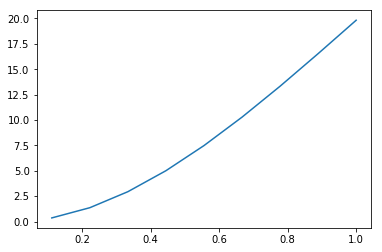

In [22]:
#Static solution

F[-2] = 10000

d = np.matmul(inv(K),F) 

plt.plot(x[1:],d[0::2])

In [23]:
w, v = linalg.eig(K,M)

In [24]:
w_fundamental = np.sqrt(np.real(w.min())) #Lowest eigenfrequency
print(w_fundamental)

0.670653612873


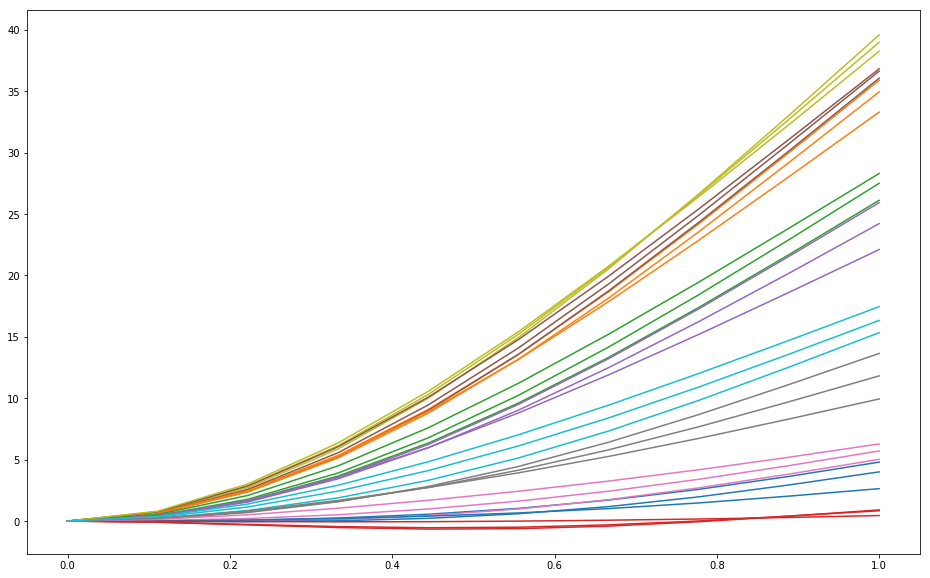

In [187]:
#Timestepping Theta Scheme
Theta = 1/2
d_old = d0[2:]
dt_old = d0[2:]
n_timesteps = 3000
#D = np.zeros([n_nodes, n_timesteps])
#D[:,0] = dz0

dt = 1
omega = 0

Minv = inv(M)
MinvK = np.matmul(Minv, K)
Q = inv(M + (Theta*dt)**2*K)
P = (M - dt**2*Theta*(1-Theta)*K)
F = np.zeros(n_dofs) 
F = F[2:]
F_new = F

r_end = []
rt_end = []
f = []

plt.figure(figsize=(16,10))

D = np.zeros([n_timesteps, n_nodes])

for i in range(n_timesteps):
    
    #dt_i = -np.matmul(Minv, np.matmul(K,d_i)-F)
    #fi = np.random.random()*np.sin(i*dt)
    #fi = 10000*np.sin(w_fundamental*i*dt*2*np.pi) #~resonance frequency
    fi = 10000*np.cos(omega*i*dt*2*np.pi)
    f.append(fi)
    
    F_old = F_new
    F_new[-2] = fi
    
    
    d_new = np.matmul(Q, np.matmul(P, d_old)) + dt*np.matmul(Q, np.matmul(M,dt_old)) + dt**2*np.matmul(Q, (Theta**2*F_new + Theta*(1-Theta)*F_old))
    
    dt_new = dt_old - dt*np.matmul(MinvK, (Theta*d_new + (1-Theta)*d_old)) + dt*np.matmul(Minv, (Theta*F_new+(1-Theta)*F_old))
    
    dz = d_new[0:-1:2]
    dz = np.insert(dz,0,0)
    #dz = np.append(dz,0)
    
    r_end.append(dz[-1])
    rt_end.append(dt_new[-2])
    
    d_old = d_new
    dt_old = dt_new
    
    D[i, :] = dz
    
    if i%100 == 0:
        plt.plot(x, dz)
    
plt.show()

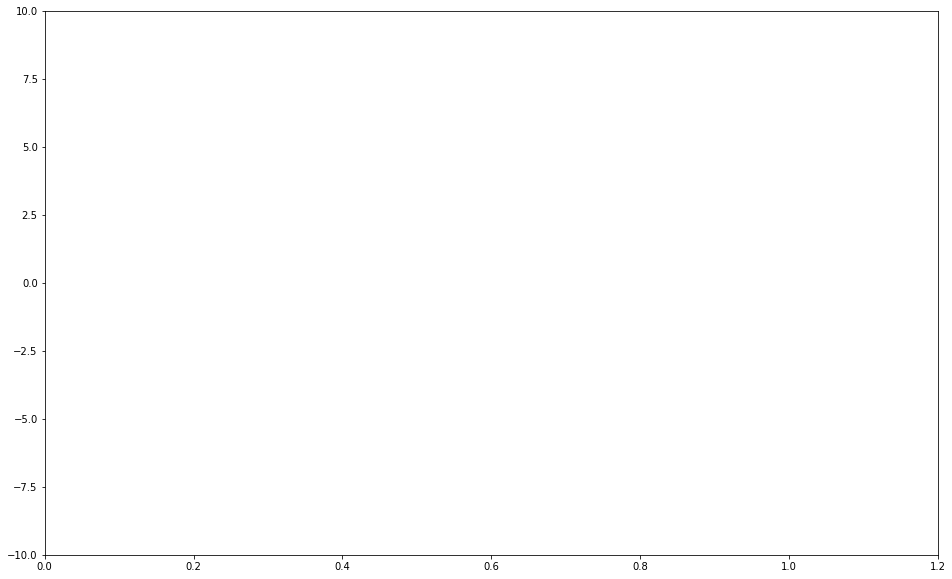

In [188]:


# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(16,10))

ax = plt.axes(xlim=(0, 1.2), ylim=(-10, 10))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x_s = x
    y = D[i,:]
    line.set_data(x_s, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=100, blit=True)



In [189]:
HTML(anim.to_jshtml())


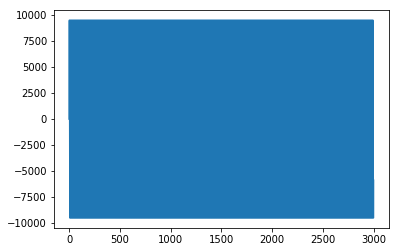

In [28]:
plt.plot(f)

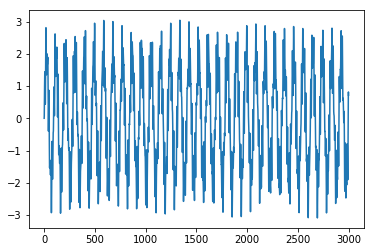

In [29]:
plt.plot(r_end)

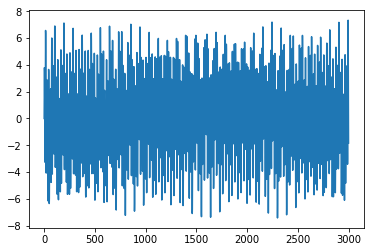

In [30]:
plt.plot(rt_end)


In [35]:
max(r_end)

3.0398454248291653

In [32]:
#Training data

d = 10 #number of steps in "model memory"
t = d

X_train = np.zeros([d*3+1, n_timesteps-d])
Y_train = np.zeros([2, n_timesteps-d])

r_max = max(r_end)
rt_max = max(rt_end)
for i in range(n_timesteps-d):
    X_train[0:d+1,i] = np.array(f[t-d:t+1])*1/10000
    X_train[d+1:2*d+1,i] = r_end[t-d:t]/r_max
    X_train[(2*d+1):,i] = np.array(rt_end[t-d:t])/rt_max
    
    Y_train[:, i] = [r_end[t]/r_max, rt_end[t]/rt_max]
    t += 1


In [33]:
#Neural network

train_portion = 0.8
input_dim = len(X_train[:,0])

x_train = X_train[:,0:int(n_timesteps*train_portion)]
x_test = X_train[:,int(n_timesteps*(train_portion)):]
y_train = Y_train[:,0:int(n_timesteps*train_portion)]
y_test = Y_train[:,int(n_timesteps*(train_portion)):]

def baseline_model():
    model = Sequential()
    height = 100
    model.add(Dense(height, input_dim=input_dim, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(height, input_dim=height, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(height, input_dim=height, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(2, input_dim=height, activation='linear', kernel_initializer='normal'))
    
    model.compile(loss='mse', optimizer="adam")
    return model



# Training the model
model = baseline_model()
model.fit(np.transpose(x_train), np.transpose(y_train), epochs=500, verbose = 0)

KeyboardInterrupt: 

In [ ]:
predictions = model.predict(np.transpose(x_test))

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(predictions[:,0], 'x')
plt.plot(y_test[0,:])
plt.show()

In [144]:
#Errorfunction
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [ ]:
#Error
print(rmse(predictions[:,0], y_test[0,:]))

In [ ]:
#Errorplot
plt.plot(np.sqrt((y_test[0,:]-predictions[:,0])**2))

In [ ]:
#independent prediction

input_i = np.copy(x_test[:,0])
r = input_i[d+1:2*d+1]
rt = input_i[2*d+1:]

preds = []
force = np.copy(x_test[0:d+1,:])
for i in range(500):
    
    
    pred = model.predict(np.reshape(input_i,(1,len(input_i))))
    preds.append(pred[0][0])
    
    input_i[0:d+1] = force[:,i+1]
    
    r = np.delete(r, 0)
    r = np.append(r, pred[0][0])
    rt = np.delete(rt, 0)
    rt = np.append(rt, pred[0][1])
    input_i[d+1:2*d+1] = r
    input_i[2*d+1:] = rt
    

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(preds[0:500])
plt.plot(y_test[0,0:500])
plt.show()

In [ ]:
print(rmse(preds, y_test[0,:len(preds)]))

In [ ]:
#Errorplot
plt.plot(np.sqrt((y_test[0,:len(preds)]-preds)**2))

In [211]:
def get_training_data(p, omega, dt, d, cycles):

    #Timestepping Theta Scheme
    Theta = 1/2
    d_old = d0[2:]
    dt_old = d0[2:]
    
    
    #_timesteps = int(cycles/(omega*dt))
    #D = np.zeros([n_nodes, n_timesteps])
    #D[:,0] = dz0
    n_timesteps = 3000
    
    Minv = inv(M)
    MinvK = np.matmul(Minv, K)
    Q = inv(M + (Theta*dt)**2*K)
    P = (M - dt**2*Theta*(1-Theta)*K)
    F = np.zeros(n_dofs) 
    F = F[2:]
    F_new = F

    r_end = []
    rt_end = []
    f = []

    D = np.zeros([n_timesteps, n_nodes])

    for i in range(n_timesteps):

        #dt_i = -np.matmul(Minv, np.matmul(K,d_i)-F)
        #fi = np.random.random()*np.sin(i*dt)
        #fi = 10000*np.sin(w_fundamental*i*dt*2*np.pi) #~resonance frequency
        
        fi = p*np.sin(omega*i*dt*2*np.pi)
        f.append(fi)

        F_old = F_new
        F_new[-2] = fi


        d_new = np.matmul(Q, np.matmul(P, d_old)) + dt*np.matmul(Q, np.matmul(M,dt_old)) + dt**2*np.matmul(Q, (Theta**2*F_new + Theta*(1-Theta)*F_old))

        dt_new = dt_old - dt*np.matmul(MinvK, (Theta*d_new + (1-Theta)*d_old)) + dt*np.matmul(Minv, (Theta*F_new+(1-Theta)*F_old))

        dz = d_new[0:-1:2]
        dz = np.insert(dz,0,0)
        #dz = np.append(dz,0)

        r_end.append(dz[-1])
        rt_end.append(dt_new[-2])

        d_old = d_new
        dt_old = dt_new

        D[i, :] = dz



    d = 10 #number of steps in "model memory"
    t = d

    X_train = np.zeros([n_timesteps-d, d*3+1])
    Y_train = np.zeros([n_timesteps-d, 2])

    #_max = max(abs(np.array(f)))
    #_max = max(abs(np.array(r_end)))
    #t_max = max(abs(np.array(rt_end)))
    for i in range(n_timesteps-d):
        X_train[i,0:d+1] = np.array(f[t-d:t+1])#f_max
        X_train[i,d+1:2*d+1] = r_end[t-d:t]#r_max
        X_train[i,(2*d+1):] = np.array(rt_end[t-d:t])#rt_max

        Y_train[i, :] = [r_end[t], rt_end[t]]
        t += 1


    train_portion = 0.8
    input_dim = len(X_train[:,0])

    x_train = X_train[0:int(n_timesteps*train_portion), :]
    x_test = X_train[int(n_timesteps*(train_portion)):, :]
    y_train = Y_train[0:int(n_timesteps*train_portion), :]
    y_test = Y_train[int(n_timesteps*(train_portion)):, :]


    return x_train, x_test, y_train, y_test

In [212]:

omegas = [0.001, 0.002, 0.005, 0.01, 0.05] #0.2, 0.5, 1, 2, 5]
forces = [10000] #,2000,5000,10000,20000,50000]

counter = 0
f=10000
for p in forces:
    
    for omega in omegas:

        x_train, x_test, y_train, y_test = get_training_data(f, omega, 1, 10, 50)

        if counter == 0:
            X_train = x_train
            Y_train = y_train
            X_test = x_test
            Y_test = y_test

        else:

            X_train = np.concatenate((X_train, x_train), axis=0)
            Y_train = np.concatenate((Y_train, y_train), axis=0)
            X_test = np.concatenate((X_test, x_test), axis=0)
            Y_test = np.concatenate((Y_test, y_test), axis=0)
        
        if counter % 1000 == 0:
            f = np.random.random()*10000

        counter += 1

r_max = max(abs(Y_train[0,:]))
rt_max = max(abs(Y_train[1,:]))
f_max = 10000

X_train = X_train[:,0:d+1]/f_max
X_test = X_test[:,0:d+1]/f_max

X_train = X_train[:, d+1:2*d+1]/r_max
X_test = X_test[:, d+1:2*d+1]/r_max
Y_train = Y_train[:,0]/r_max
Y_test = Y_test[:,0]/r_max

X_train = X_train[:,2*d+1:]/rt_max
X_test = X_test[:, 2*d+1:]/rt_max
Y_train = Y_train[:,1]/rt_max
Y_test = Y_test[:,1]/rt_max

[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [213]:
np.random.random()

0.3421663088623569

In [198]:
#Neural network

input_dim = len(X_train[0,:])


def baseline_model():
    model = Sequential()
    height = 100
    model.add(Dense(height, input_dim=input_dim, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(height, input_dim=height, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(height, input_dim=height, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(2, input_dim=height, activation='linear', kernel_initializer='normal'))
    
    model.compile(loss='mse', optimizer="adam")
    return model



# Training the model
model = baseline_model()
model.fit(X_train, Y_train, epochs=500, verbose = 0)

In [199]:
predictions = model.predict(X_test)

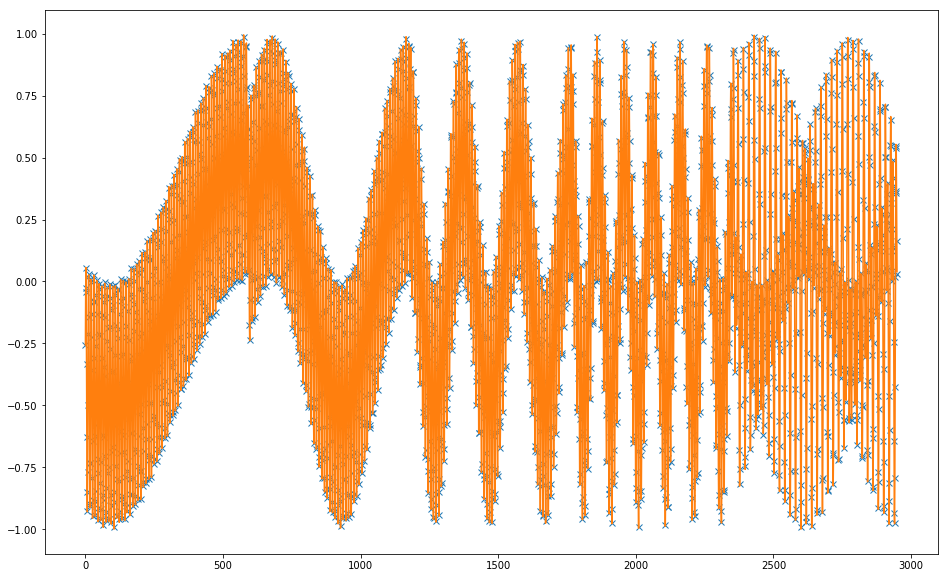

In [200]:
plt.figure(figsize=(16,10))
plt.plot(predictions[:,0], 'x')
plt.plot(Y_test[:,0])
plt.show()

In [201]:
print(rmse(predictions[:,0], Y_test[:,0]))

0.00385289060031


In [204]:
#independent prediction

input_i = np.copy(X_test[0,:])
r = input_i[d+1:2*d+1]
rt = input_i[2*d+1:]

preds = []
force = np.copy(X_test[:, 0:d+1])
for i in range(2800):
    
    
    pred = model.predict(np.reshape(input_i,(1,len(input_i))))
    preds.append(pred[0][0])
    
    input_i[0:d+1] = force[i+1, :]
    
    r = np.delete(r, 0)
    r = np.append(r, pred[0][0])
    rt = np.delete(rt, 0)
    rt = np.append(rt, pred[0][1])
    input_i[d+1:2*d+1] = r
    input_i[2*d+1:] = rt
    

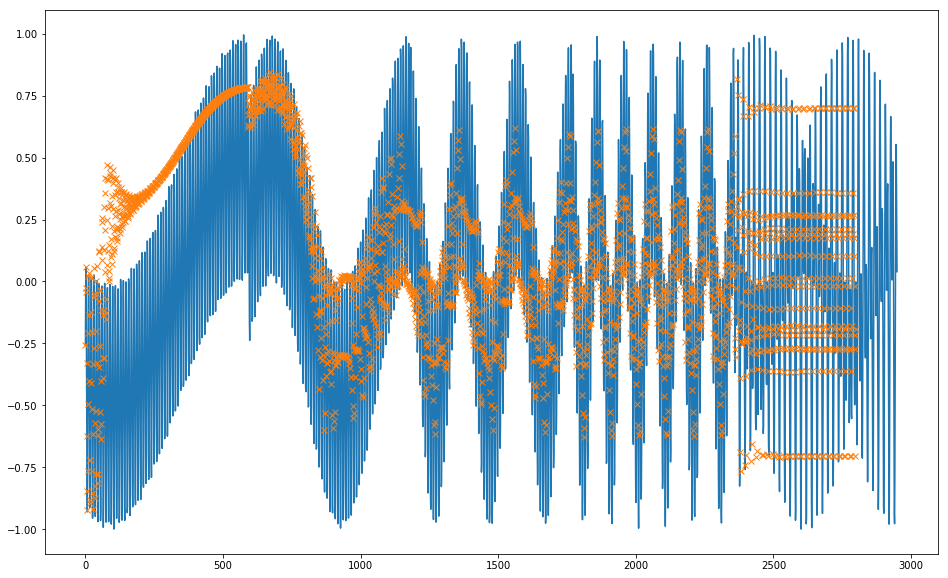

In [206]:
plt.figure(figsize=(16,10))

plt.plot(Y_test[:,0])
plt.plot(preds[:], 'x')
plt.show()

In [174]:
print(rmse(preds, Y_test[:len(preds),0]))

0.0126037301373


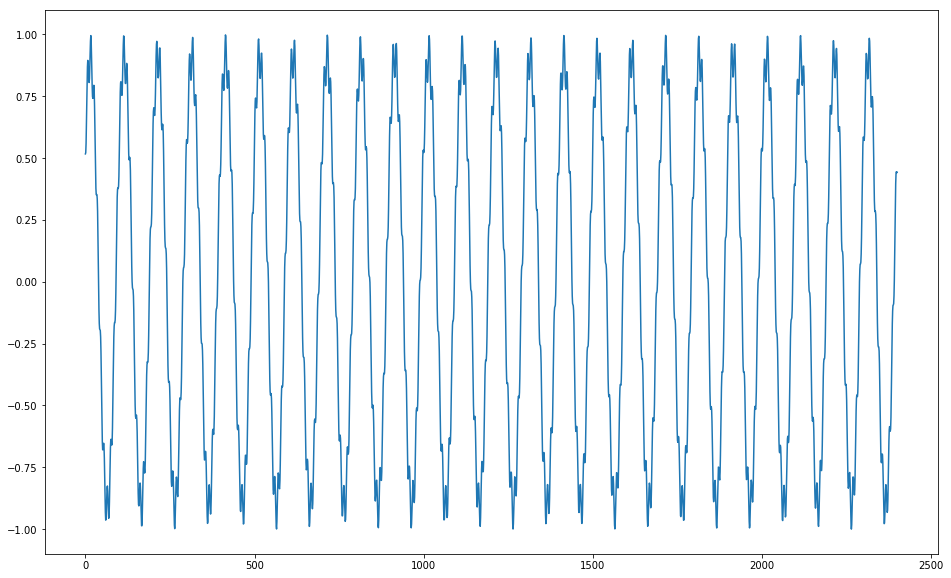

In [152]:
plt.figure(figsize=(16,10))
plt.plot(Y_train[:,0])